<a href="https://colab.research.google.com/github/galalqassas/xai/blob/main/notebooks/Decision%20Tree/Mohamed_Decision_Tree.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Imports**

In [1]:
%%capture
!pip install -q lime shap

In [2]:
import numpy as np, pandas as pd
import matplotlib.pyplot as plt, seaborn as sns
import kagglehub
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import SMOTE
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
import warnings
warnings.filterwarnings('ignore')
from sklearn.metrics import RocCurveDisplay, PrecisionRecallDisplay
from sklearn.model_selection import learning_curve
from sklearn.inspection import PartialDependenceDisplay
import shap
from lime import lime_tabular
import joblib
from sklearn import tree

# **Utils**

In [4]:
def our_confusion_matrix(model, name='Model'):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,8))
    ConfusionMatrixDisplay.from_estimator(model, X_train, y_train, cmap="Oranges", ax=ax1)
    ConfusionMatrixDisplay.from_estimator(model, X_test, y_test, cmap="Oranges", ax=ax2)
    plt.title(f"{name} Confusion Matrix")

def our_roc(model, name="Model"):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
    roc1 = RocCurveDisplay.from_estimator(
    model, X_train, y_train,
    name=name, ax=ax1,
    color="orange" #juicy juicy
    )
    roc2 = RocCurveDisplay.from_estimator(
        model, X_test, y_test,
        name=name, ax=ax2,
        color="orange" #juicy juicy
    )
    ax1.fill_between(roc1.fpr, roc1.tpr, alpha=0.4, color="orange")
    ax2.fill_between(roc2.fpr, roc2.tpr, alpha=0.4, color="orange")
    ax1.set_title(f"{name} Training ROC Curve", fontsize=16)
    ax2.set_title(f"{name} Testing ROC Curve", fontsize=16)
    for ax in [ax1, ax2]:
        ax.grid(alpha=0.5)

def our_learning_curve(model, name='Model'):
    train_sizes, train_scores, test_scores = learning_curve(
        model, X_train, y_train, cv=5, scoring='accuracy',
        train_sizes=np.linspace(0.1, 1.0, 10), random_state=0
    )

    plt.figure(figsize=(13, 8))
    plt.plot(train_sizes, np.mean(train_scores, axis=1), 'o-', color="mediumseagreen", label="Training score")
    plt.plot(train_sizes, np.mean(test_scores, axis=1), 'o-', color="royalblue", label="Cross-validation score")
    plt.title(f"{name} Learning Curve")
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    plt.legend(loc="best")
    plt.grid(alpha=0.5)

def our_prc(model, name="Model"):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(21, 13))
    train_disp = PrecisionRecallDisplay.from_estimator(model, X_train, y_train, ax=ax1, color='orange')
    test_disp = PrecisionRecallDisplay.from_estimator(model, X_test, y_test, ax=ax2, color='orange')
    ax1.set_title(f"{name} Precision-Recall Curve - Train")
    ax2.set_title(f"{name} Precision-Recall Curve - Test")
    ax1.fill_between(train_disp.recall, train_disp.precision, alpha=0.4, color='orange')
    ax2.fill_between(test_disp.recall, test_disp.precision, alpha=0.4, color='orange')

def plot_lime_explanation(model, instance, explainer, feature_names, class_names=None, save_path='results/single_lime_explanation.png'):

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 15))
    if isinstance(instance, pd.Series):
        instance_values = instance.values
    else:
        instance_values = instance
    pred_class = model.predict([instance_values])[0]
    pred_prob = model.predict_proba([instance_values])[0][pred_class]
    exp = explainer.explain_instance(
        instance_values,
        model.predict_proba,
        num_features=10
    )

    ax1.barh(feature_names, instance_values, color='skyblue')
    ax1.set_title('Feature Values')
    ax1.set_xlabel('Value')
    ax1.invert_yaxis()


    lime_features = exp.as_list()
    features = [f[0] for f in lime_features]
    contributions = [f[1] for f in lime_features]
    colors = ['green' if c > 0 else 'red' for c in contributions]

    ax2.barh(features, contributions, color=colors)
    ax2.set_title(f'LIME Explanation\nPredicted: {class_names.get(pred_class, pred_class)} ({pred_prob:.2f})')
    ax2.axvline(0, color='black', linestyle='--')
    ax2.set_xlabel('Contribution to Prediction')
    ax2.invert_yaxis()

    plt.tight_layout()
    plt.show()

# **Load Processed Dat**a

In [5]:
path = kagglehub.dataset_download('mohamedhassan77/xai-project-processed-data')
df = pd.read_csv(f"{path}/combined_adasyn_train_test.csv")
df

,Age,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EnvironmentSatisfaction,Gender,HourlyRate,...,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager,promotion_velocity,workload_score,compensation_ratio,Attrition,Set
0,31,2,1062,1,24,3,3,3,0,96,...,3,10.0,9,1,8,9.999900,1,1.019760,0,Train
1,50,2,328,1,1,3,3,3,1,86,...,2,3.0,2,0,2,300000.000000,2,1.281918,0,Train
2,46,2,717,1,13,4,1,3,1,34,...,3,10.0,7,0,9,1000000.000000,1,0.832635,0,Train
3,44,2,170,1,1,4,1,2,1,78,...,3,2.0,0,2,2,0.999995,1,0.753443,0,Train
4,26,1,1479,1,1,3,1,3,0,84,...,1,6.0,5,1,4,5.999940,3,1.007878,0,Train
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2042,56,2,1162,1,24,2,1,1,1,97,...,3,4.0,2,1,0,3.999960,1,0.898732,1,Test
2043,46,2,669,2,9,2,3,3,1,64,...,3,9.0,8,4,7,2.249994,1,1.558490,1,Test
2044,30,2,1240,0,9,3,0,3,1,48,...,1,11.0,9,4,7,2.749993,7,2.052053,0,Test
2045,31,2,741,1,2,4,1,2,1,69,...,4,5.0,2,0,3,500000.000000,0,1.207921,0,Test


In [6]:
train_df = df[df['Set'] == 'Train'].drop(columns=['Set'])
test_df = df[df['Set'] == 'Test'].drop(columns=['Set'])

X_train = train_df.drop(columns=['Attrition'])
y_train = train_df['Attrition']

X_test = test_df.drop(columns=['Attrition'])
y_test = test_df['Attrition']

print("X_train:", X_train.shape, "y_train:", y_train.shape)
print("X_test:", X_test.shape, "y_test:", y_test.shape)

X_train: (1589, 33) y_train: (1589,)
X_test: (458, 33) y_test: (458,)


In [7]:
feature_names = X_train.columns

# **Model Initialization**

In [8]:
decision_tree_clf = DecisionTreeClassifier(random_state=42)

# **Model Training**

In [9]:
decision_tree_clf.fit(X_train, y_train)

y_pred = decision_tree_clf.predict(X_test)

# **Model Evaluation**

In [10]:
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.7248908296943232

Classification Report:
               precision    recall  f1-score   support

           0       0.85      0.80      0.83       373
           1       0.30      0.38      0.34        85

    accuracy                           0.72       458
   macro avg       0.58      0.59      0.58       458
weighted avg       0.75      0.72      0.74       458



### Confusion Matrix

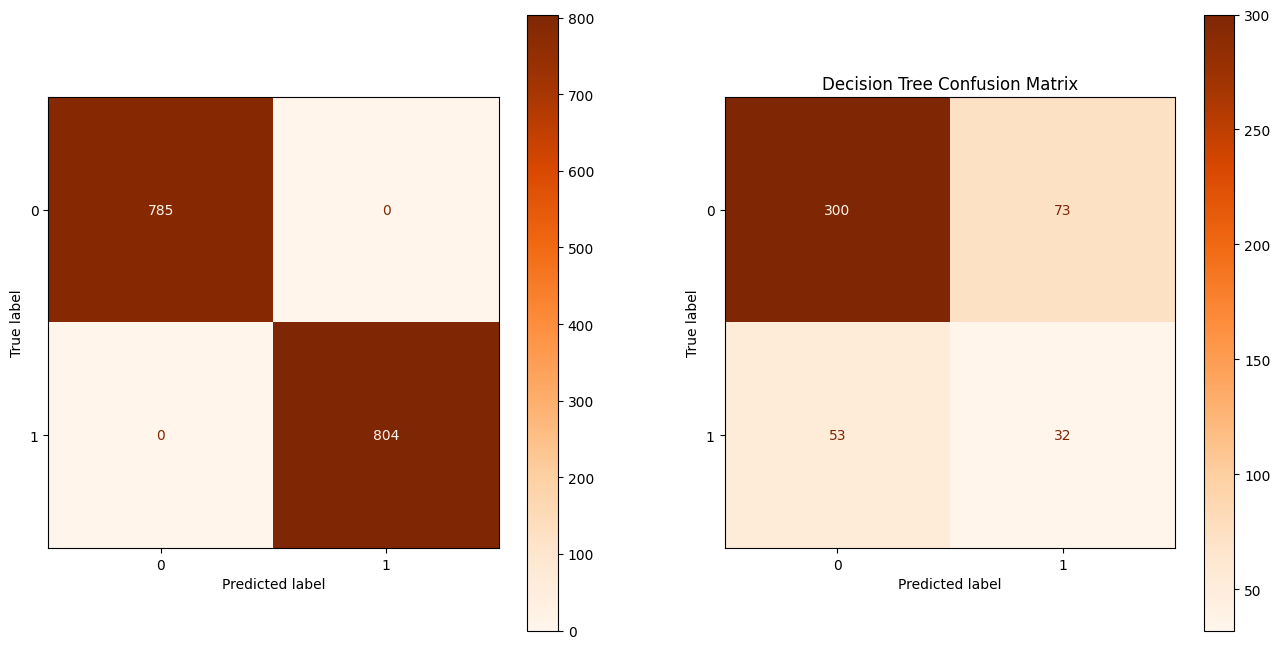

In [11]:
our_confusion_matrix(decision_tree_clf, "Decision Tree")

* The model has predicted correctly 300 from 373 from class 0 (No Attrition) but on class 1 it only predicted 32 from 85 correctly.
* It is much better at predicting who will stay than who will leave ( it is biased to class 0)

## Learning Curve

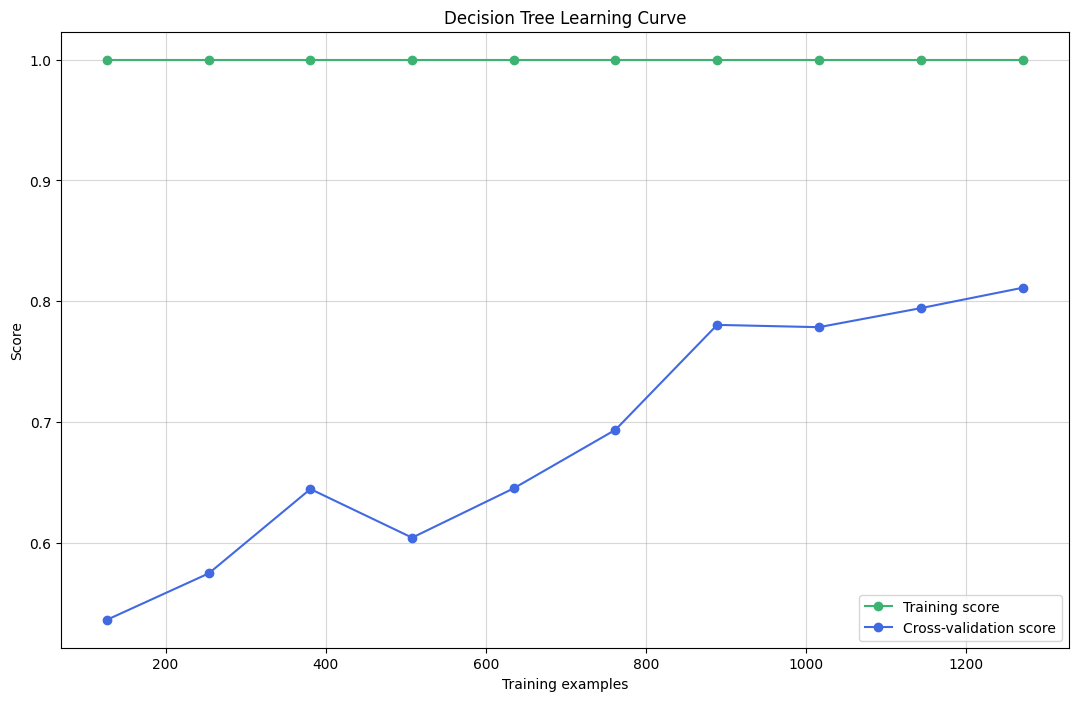

In [12]:
our_learning_curve(decision_tree_clf, "Decision Tree")

* There is a very high overfitting.
* The model learns the training data too specifically and doesn't generalize as well to new data.
* To improve: tree prunning or reduce depth

## Precision Recall Curve

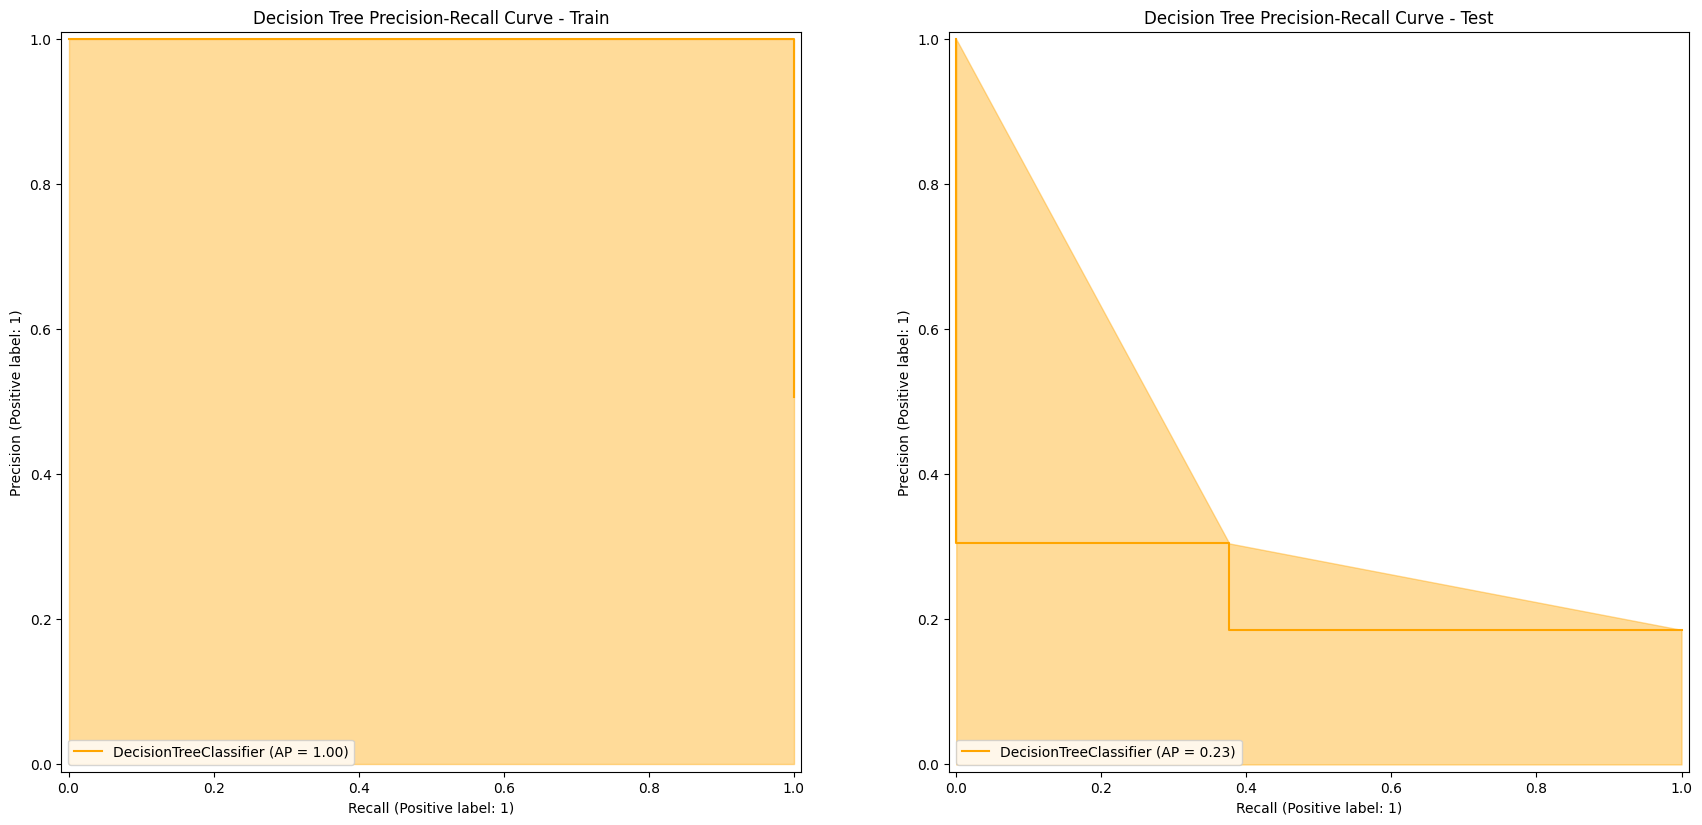

In [13]:
our_prc(decision_tree_clf, "Decision Tree")

The strong difference between the train (AP=1.00) and test (AP=0.23) curves provides strong visual evidence of overfitting and poor generalization performance for predicting attrition.

### ROC

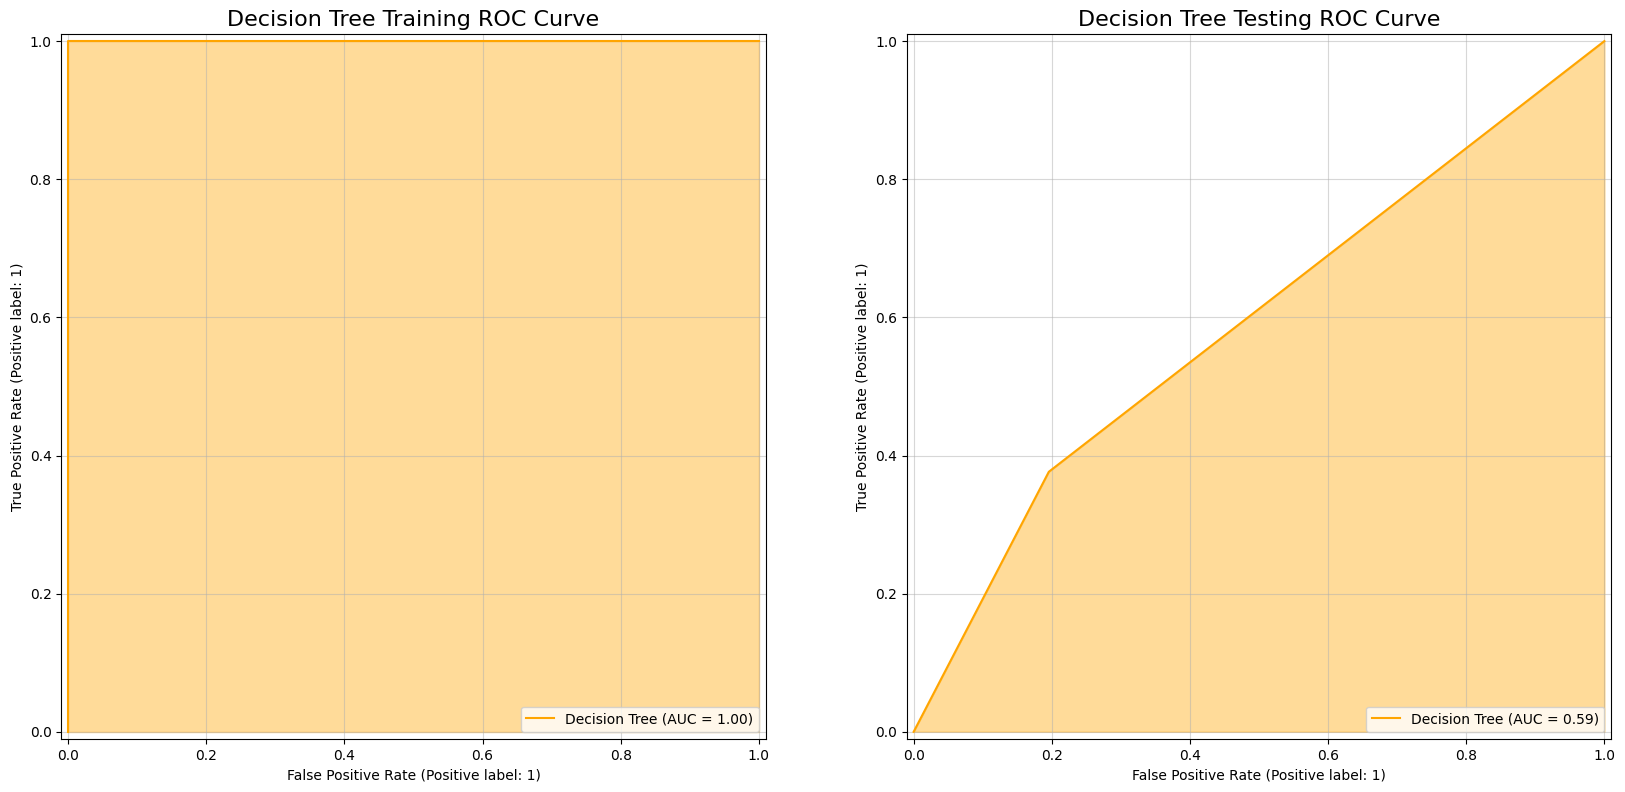

In [14]:
our_roc(decision_tree_clf, "Decision Tree")

# **Explainability Techniques**

## Decision Tree Structure

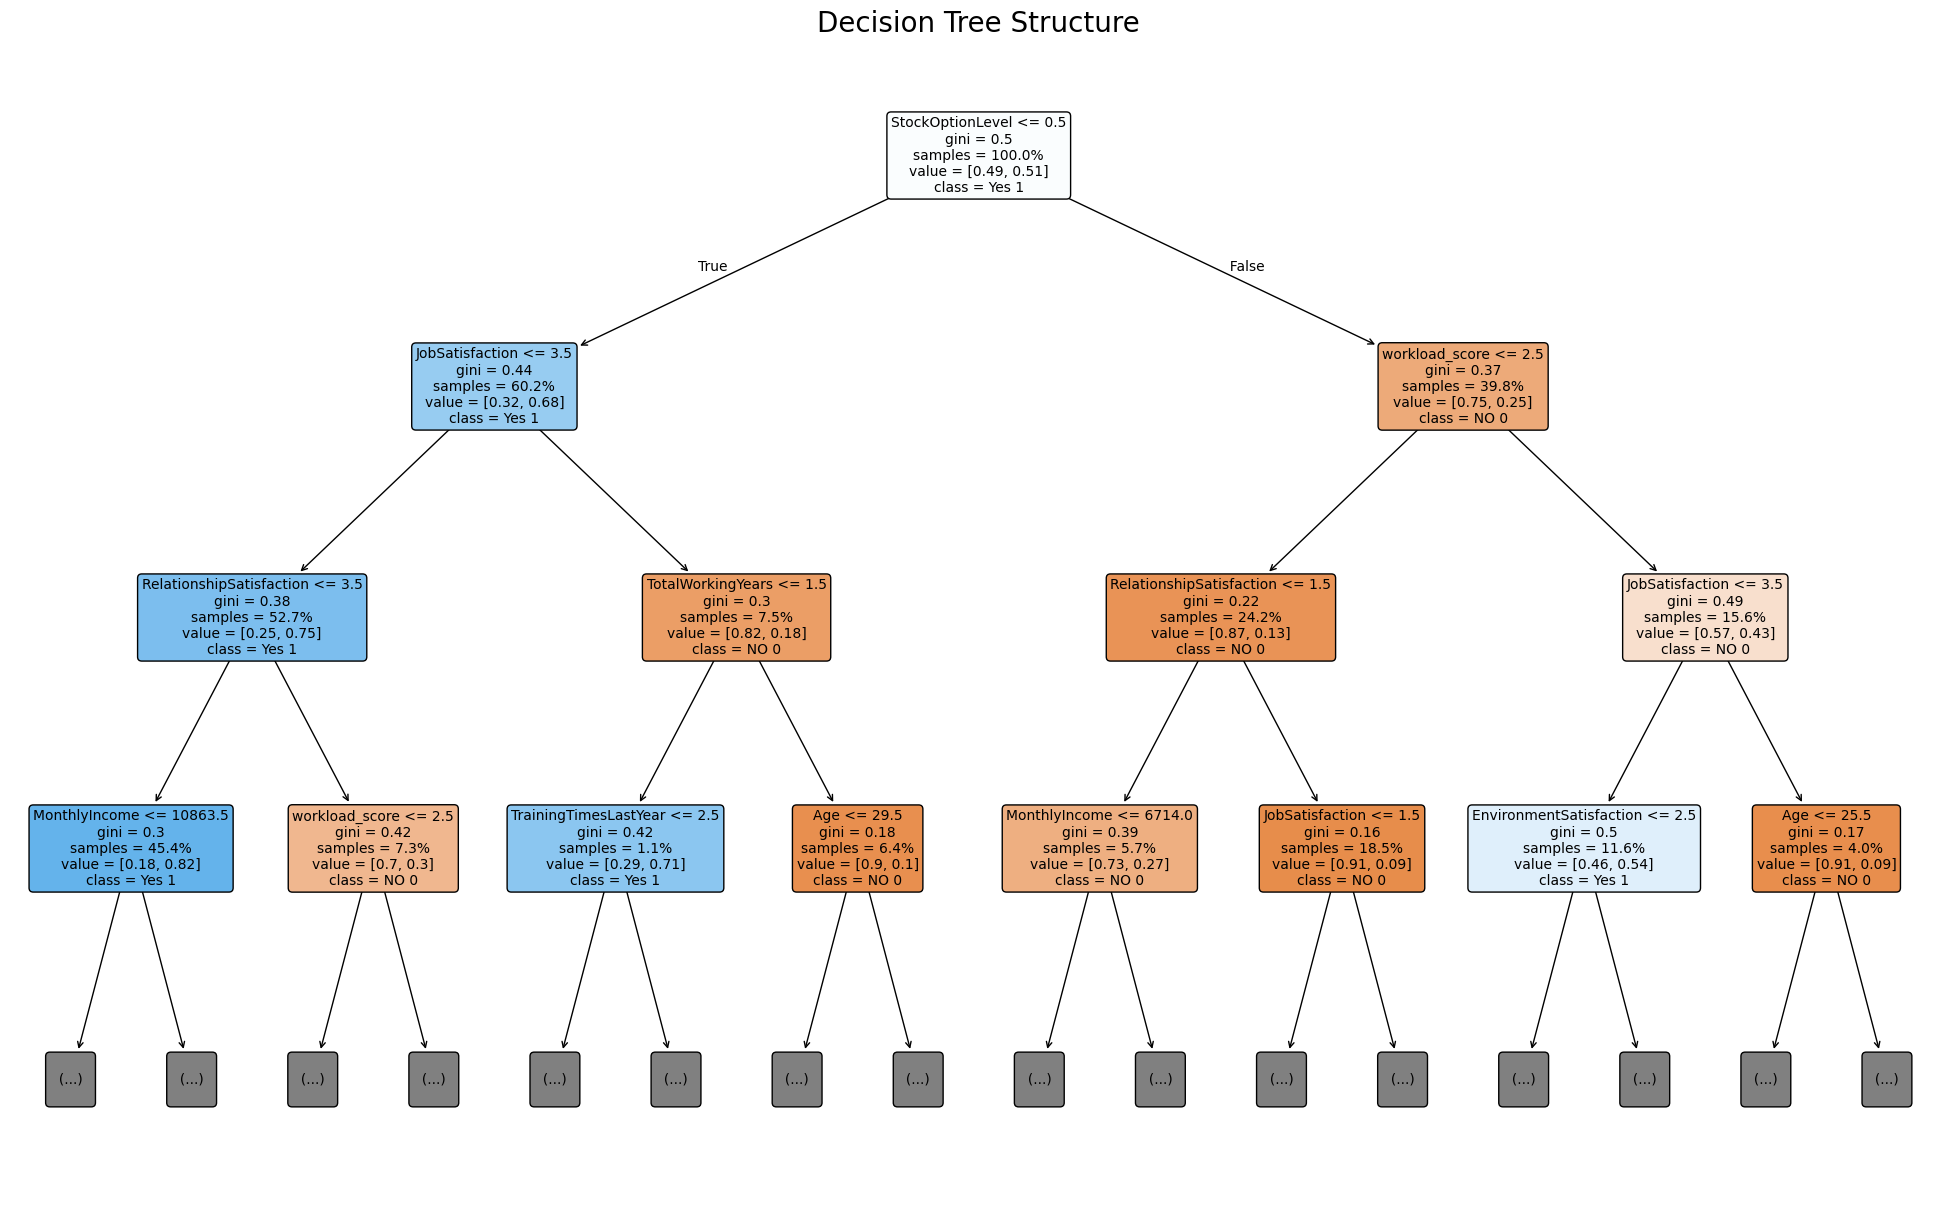

In [15]:
plt.figure(figsize=(25, 15))
tree.plot_tree(
    decision_tree=decision_tree_clf,
    feature_names=X_train.columns,
    class_names=['NO 0', 'Yes 1'],
    filled=True,
    rounded=True,
    proportion=True,
    precision=2,
    fontsize=10,
    max_depth=3
)

plt.title('Decision Tree Structure', fontsize=20)
plt.show()

## LIME Analysis

In [27]:
lime_explainer = lime_tabular.LimeTabularExplainer(
    training_data=np.array(X_train),
    feature_names=X_train.columns,
    mode='classification'
)

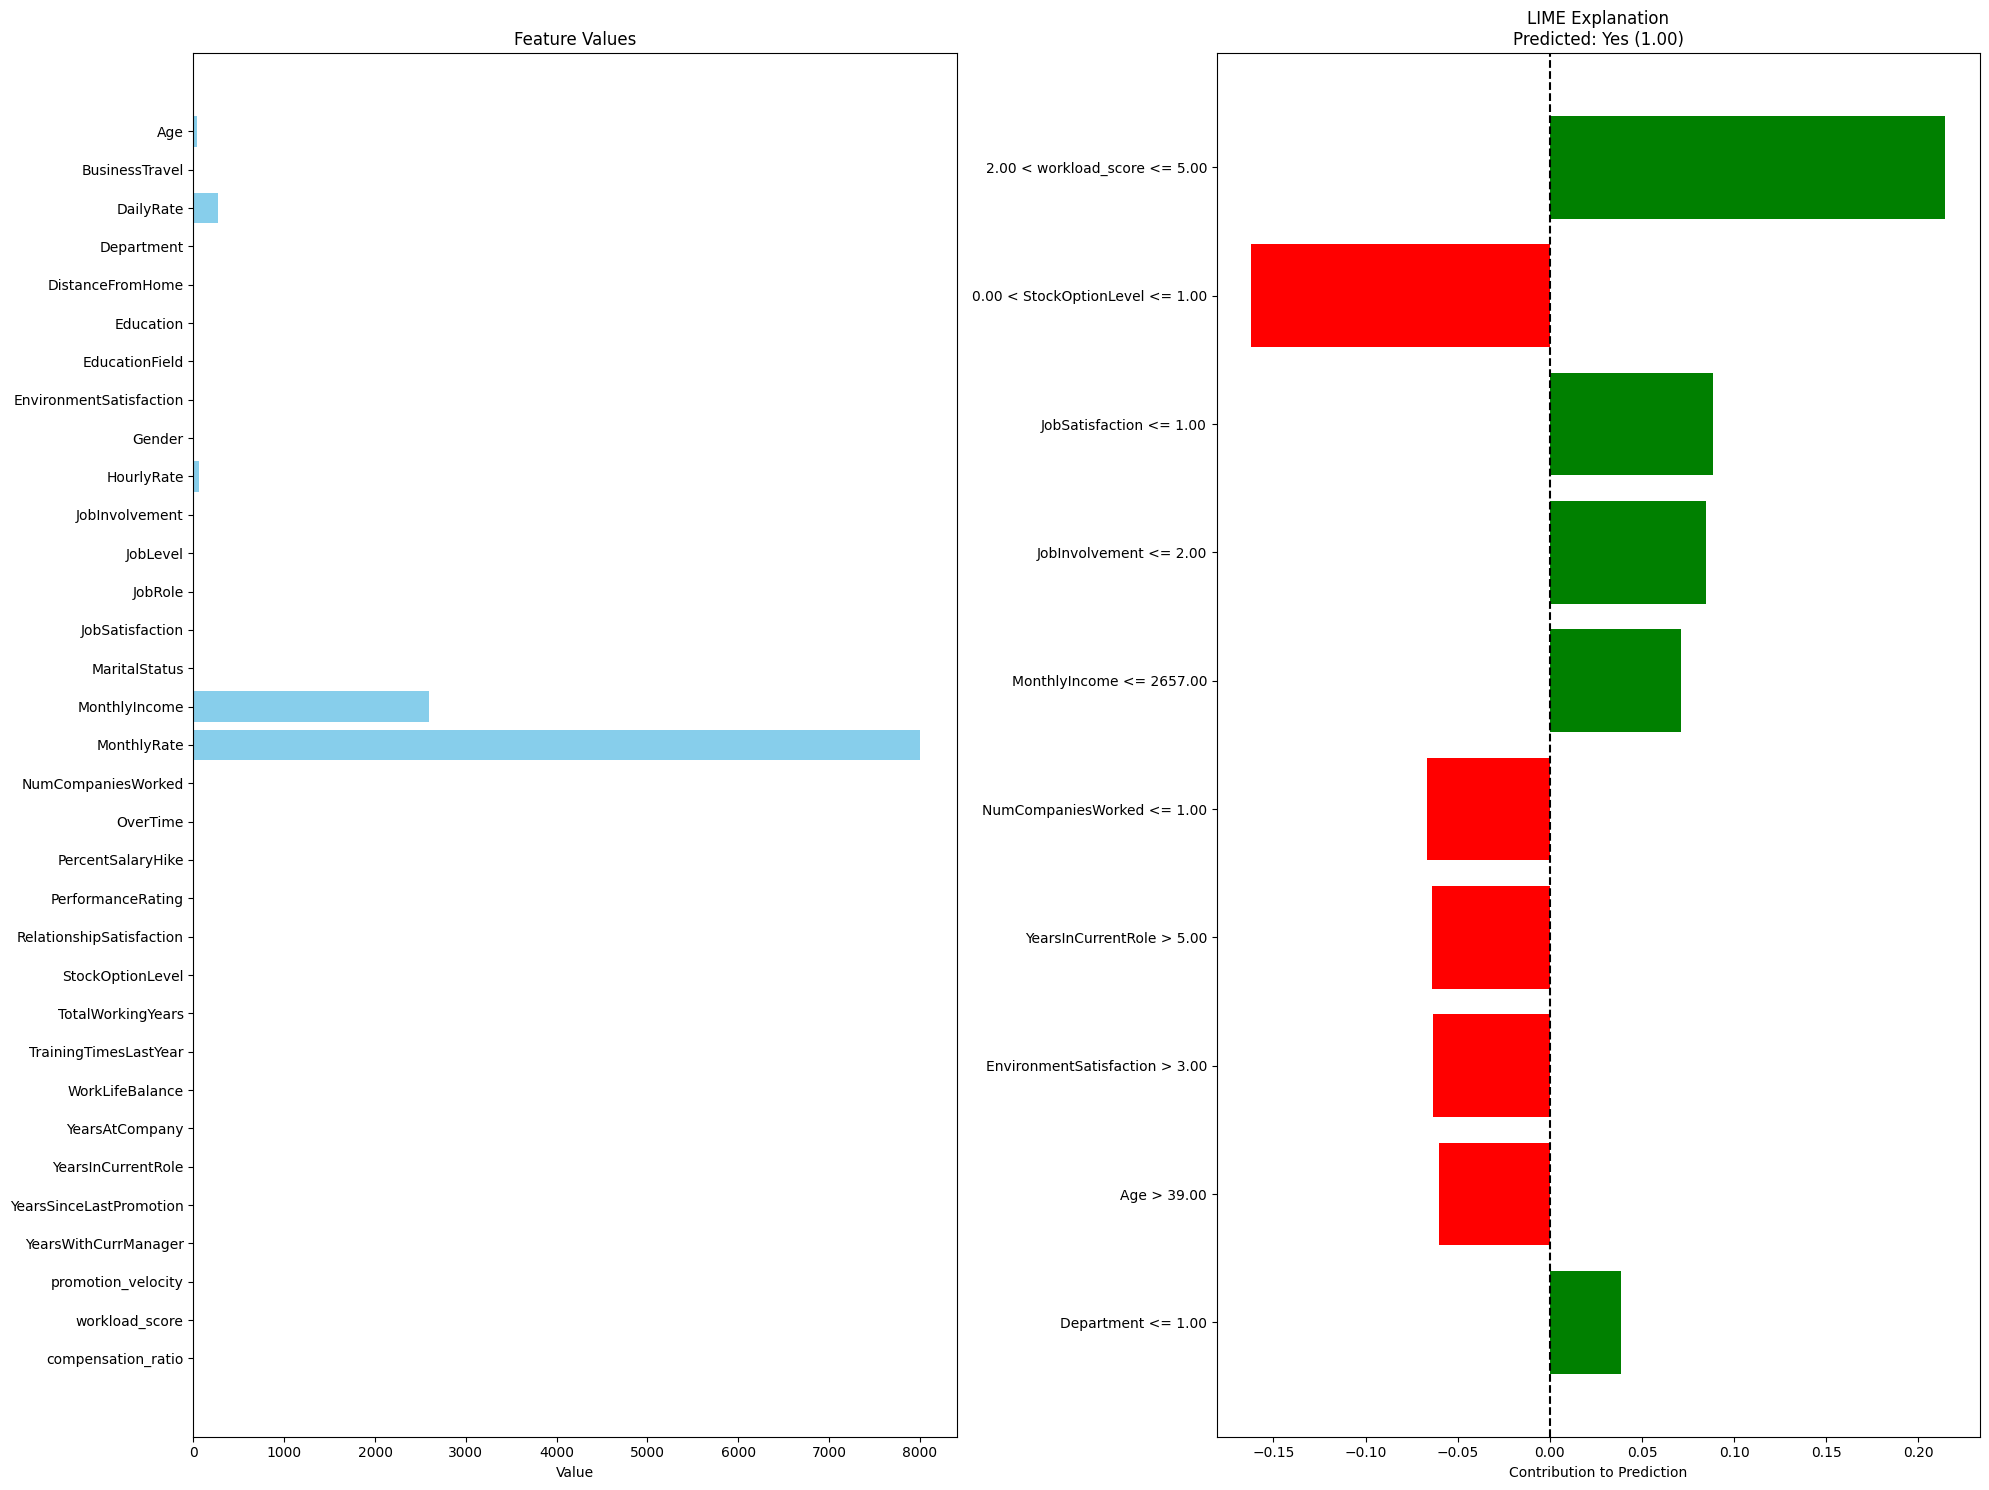

In [28]:
lime_explainer = lime_tabular.LimeTabularExplainer(
    training_data=X_train.values,
    feature_names=X_train.columns.tolist(),
    mode='classification'
)

plot_lime_explanation(
    model=decision_tree_clf,
    instance=X_test.iloc[5],
    explainer=lime_explainer,
    class_names={0: 'No', 1: 'Yes'},
    feature_names=X_test.columns
)


* **Green Bars (Positive Contribution):** These features pushed the prediction towards "Yes" (Attrition). The longer the bar, the stronger the push.

    * `2.00 < workload_score <= 5.00` (Strongest Positive): This employee's workload score falls within this range (likely indicating a high workload), and this was the most significant factor driving the model to predict attrition.
    * `JobSatisfaction <= 1.00` (Strong Positive): Very low job satisfaction (score of 1 or less) is the second biggest contributor towards predicting attrition.
    * `JobInvolvement <= 2.00` (Significant Positive): Low job involvement (score of 2 or less) also pushed the prediction towards attrition.
    * `MonthlyIncome <= 2657.00` (Significant Positive): A relatively low monthly income is another strong factor pushing towards attrition.
    * `Department <= 1.00` (Slight Positive): The specific department this employee belongs to (coded as 1 or less) slightly contributed to the attrition prediction. This might indicate higher turnover in that specific department according to the model's learned patterns.

* **Red Bars (Negative Contribution):** These features pushed the prediction away from "Yes" (Attrition) and towards "No" (Retention).

    * `0.00 < StockOptionLevel <= 1.00` (Strongest Negative): Having a stock option level in this range (likely level 1) was the strongest factor arguing against this employee leaving, according to the model.
    * `YearsInCurrentRole > 5.00` (Moderate Negative): Being in the current role for more than 5 years pushed the prediction towards retention. Longer tenure in a role often suggests stability.
    * `EnvironmentSatisfaction > 3.00` (Moderate Negative): High environment satisfaction (score above 3) argued moderately against attrition.
    * `Age > 39.00` (Slight Negative): The employee being older than 39 slightly pushed the prediction towards retention.
    * `NumCompaniesWorked <= 1.00` (Slight Negative): Having worked at 1 or fewer companies previously also slightly pushed the prediction towards retention.

## SHAP Analysis

In [19]:
explainer = shap.TreeExplainer(decision_tree_clf, X_test)
shap_values = explainer.shap_values(X_test)
shap_values

array([[[-0.18197222,  0.18197222],
        [ 0.00553571, -0.00553571],
        [-0.00753175,  0.00753175],
        ...,
        [-0.00609524,  0.00609524],
        [ 0.03839683, -0.03839683],
        [-0.06103175,  0.06103175]],

       [[ 0.0041627 , -0.0041627 ],
        [ 0.0264881 , -0.0264881 ],
        [ 0.0130119 , -0.01301191],
        ...,
        [-0.00490476,  0.00490476],
        [ 0.09873809, -0.0987381 ],
        [-0.00459524,  0.00459524]],

       [[ 0.00229762, -0.00229762],
        [ 0.00289286, -0.00289286],
        [-0.00730952,  0.00730952],
        ...,
        [-0.00283333,  0.00283333],
        [ 0.07785715, -0.07785714],
        [-0.00396429,  0.00396429]],

       ...,

       [[ 0.00198449, -0.00198449],
        [ 0.00156349, -0.00156349],
        [ 0.01344048, -0.01344048],
        ...,
        [-0.00252381,  0.00252381],
        [-0.05001155,  0.05001154],
        [-0.00544444,  0.00544444]],

       [[ 0.00145274, -0.00145274],
        [ 0.004421  , -0.00

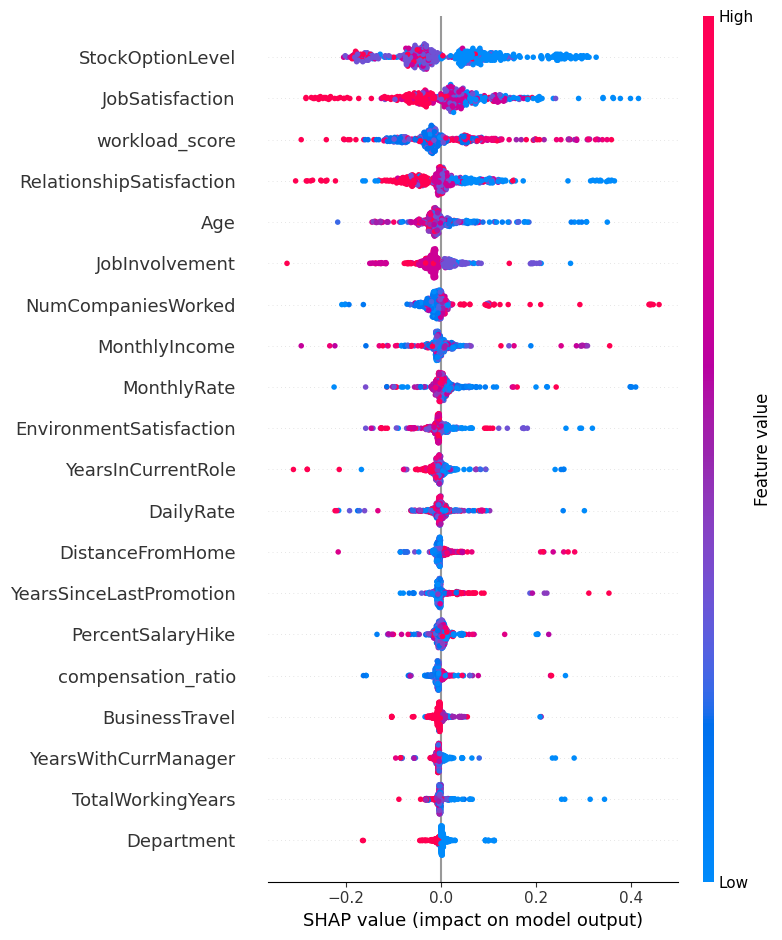

In [20]:
shap.summary_plot(shap_values[:, :, 1], X_test)

This plot summarizes how features influence the prediction of **Attrition (Class 1)** across the dataset. Features are ranked by importance (top=most important).

*   **Dot Position (X-axis):** SHAP value indicating impact magnitude and direction. Positive values (right) increase Attrition prediction; negative values (left) decrease it.
*   **Dot Color:** Represents the feature's value for that instance (Red=High, Blue=Low).

**Observations:**
*   Top predictors include `StockOptionLevel`, `JobSatisfaction`, `workload_score`.
*   Consistent trends are visible: e.g., Low `JobSatisfaction` (blue) consistently yields positive SHAP values (predicts Attrition). High `StockOptionLevel` (red) yields negative SHAP values (predicts Retention).

## Feature Importance (Model-Specific)

[Text(3, 0, '0.000'),
 Text(3, 0, '0.000'),
 Text(3, 0, '0.002'),
 Text(3, 0, '0.003'),
 Text(3, 0, '0.004'),
 Text(3, 0, '0.005'),
 Text(3, 0, '0.005'),
 Text(3, 0, '0.006'),
 Text(3, 0, '0.009'),
 Text(3, 0, '0.009'),
 Text(3, 0, '0.011'),
 Text(3, 0, '0.012'),
 Text(3, 0, '0.012'),
 Text(3, 0, '0.012'),
 Text(3, 0, '0.012'),
 Text(3, 0, '0.014'),
 Text(3, 0, '0.014'),
 Text(3, 0, '0.016'),
 Text(3, 0, '0.017'),
 Text(3, 0, '0.018'),
 Text(3, 0, '0.021'),
 Text(3, 0, '0.024'),
 Text(3, 0, '0.024'),
 Text(3, 0, '0.027'),
 Text(3, 0, '0.032'),
 Text(3, 0, '0.042'),
 Text(3, 0, '0.045'),
 Text(3, 0, '0.051'),
 Text(3, 0, '0.076'),
 Text(3, 0, '0.080'),
 Text(3, 0, '0.081'),
 Text(3, 0, '0.130'),
 Text(3, 0, '0.183')]

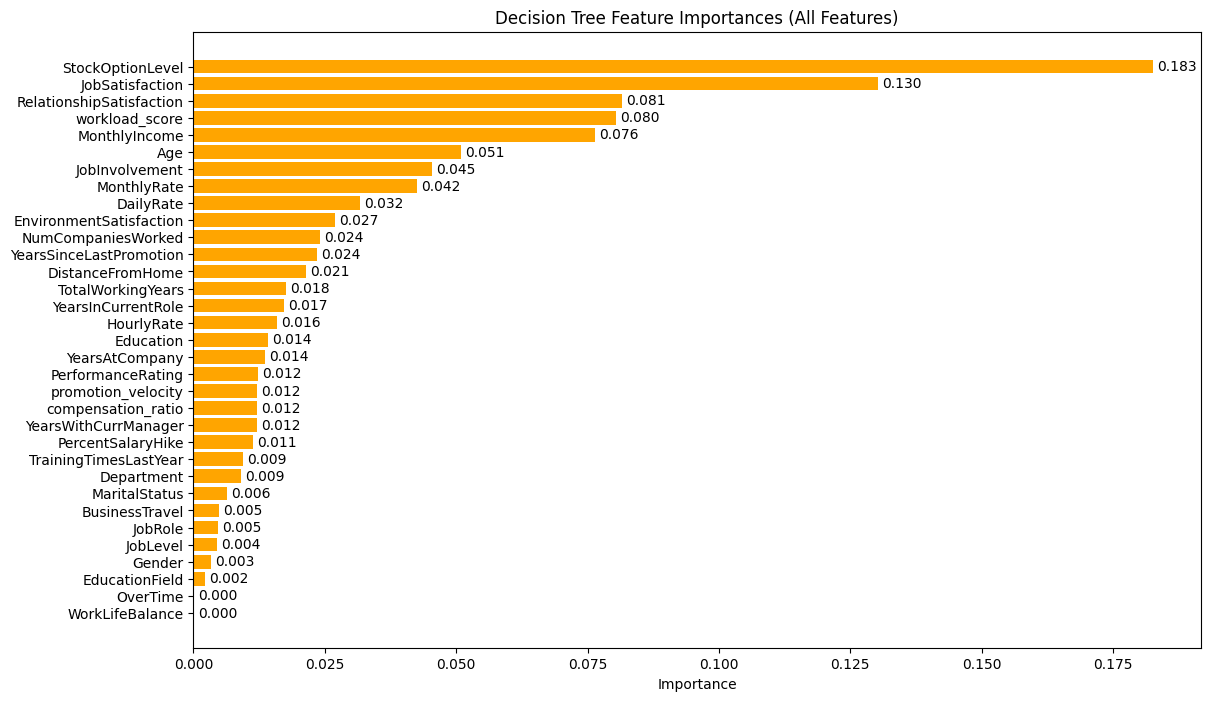

In [21]:
importances = decision_tree_clf.feature_importances_
feat_idx = np.argsort(importances)[::-1]

plt.figure(figsize=(13, 8))
ax = plt.gca()
bars = ax.barh(X_train.columns[feat_idx][::-1], importances[feat_idx][::-1], color="orange")
ax.set_xlabel("Importance")
ax.set_title("Decision Tree Feature Importances (All Features)")
ax.bar_label(bars, fmt="%.3f", padding=3, fontsize=10)

The figure shows the importance of the features according to the decison tree model.

## Partial Dependence Plots

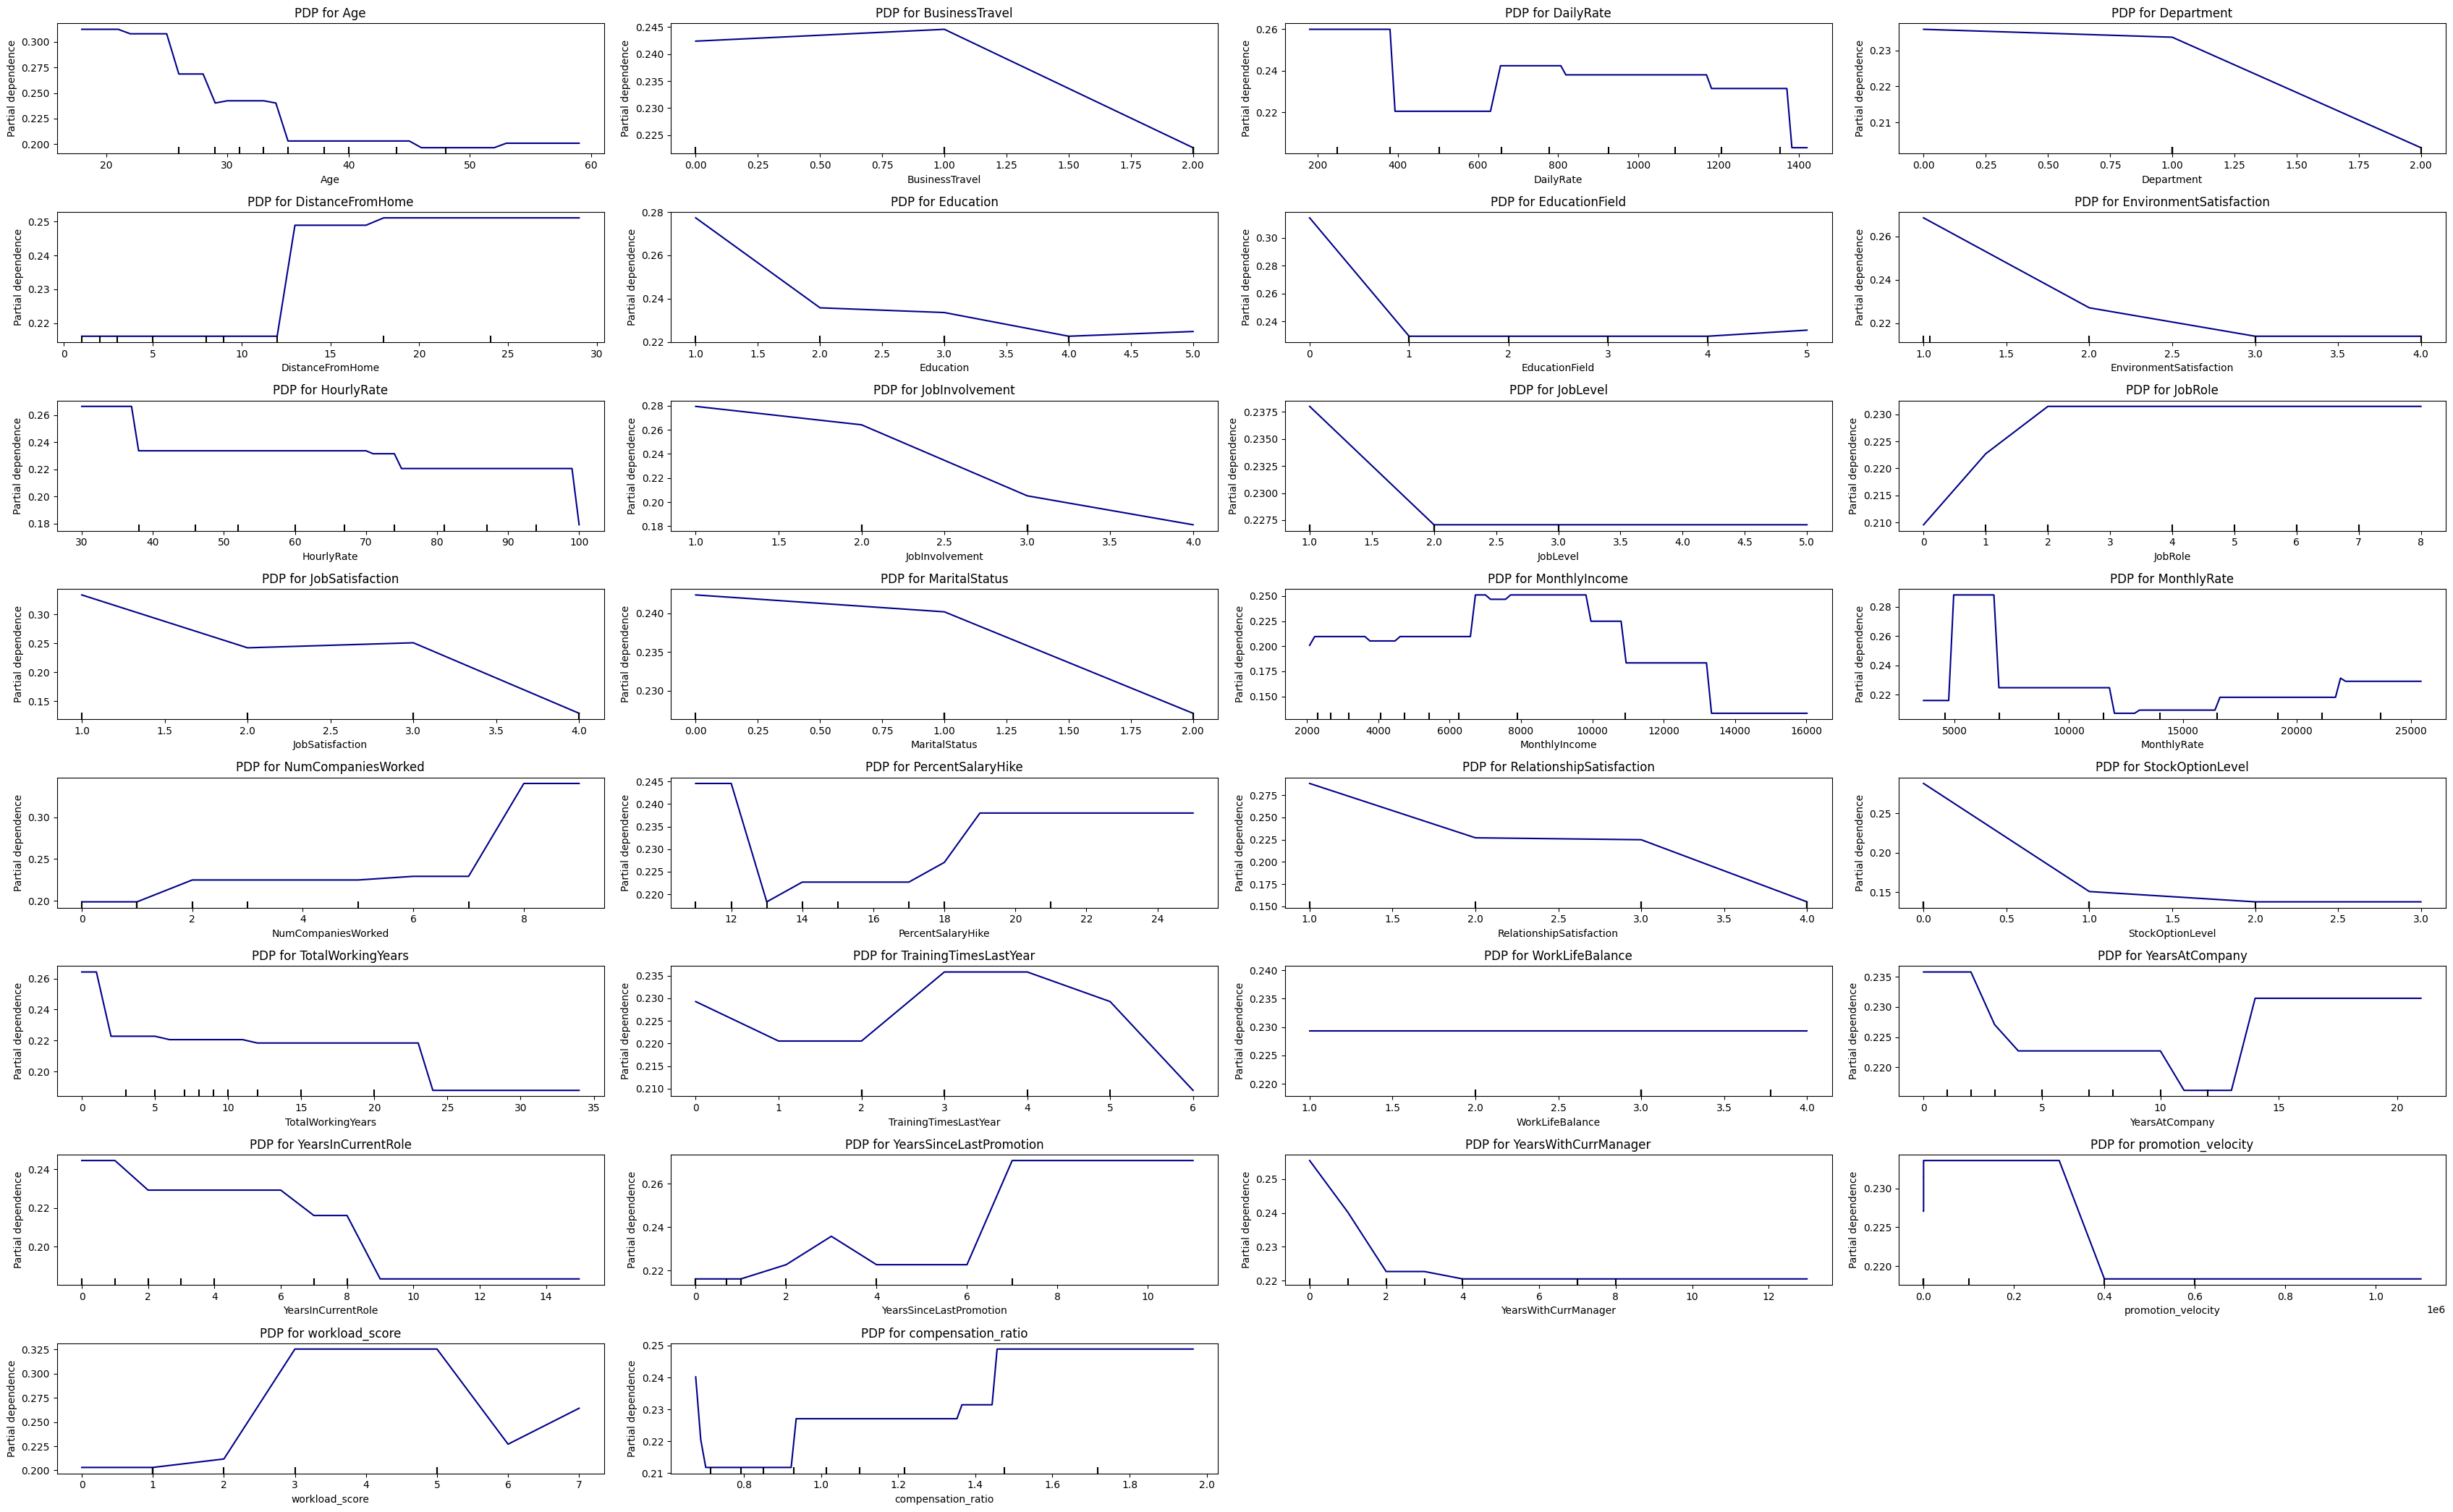

In [22]:
cols_pdp = [c for c in X_test.columns if X_test[c].nunique() > 2]

nc_pdp = 4
nr_pdp = (len(cols_pdp) + nc_pdp - 1) // nc_pdp
fig_pdp, axes_pdp = plt.subplots(nr_pdp, nc_pdp, figsize=(34, 21))

for ax, feat in zip(axes_pdp.flatten(), cols_pdp):
    PartialDependenceDisplay.from_estimator(
        estimator=decision_tree_clf,
        X=X_test,
        features=[feat],
        kind='average',
        ax=ax,
        line_kw={'color': 'darkblue'}
    )
    ax.set_title(f"PDP for {feat}")

for i in range(len(cols_pdp), nr_pdp * nc_pdp):
     if i < len(axes_pdp.flatten()):
        fig_pdp.delaxes(axes_pdp.flatten()[i])

plt.tight_layout()
plt.show()

PDP shows average effect of feature on the model prediction. It can mislead because it assumes feature independence.


**Observations:**

*   **Satisfaction Metrics (`JobSatisfaction`, `RelationshipSatisfaction`, `EnvironmentSatisfaction`):** There's a clear negative correlation. As satisfaction levels increase, the average predicted probability of attrition decreases significantly.

*   **Incentives/Compensation (`StockOptionLevel`, `MonthlyIncome`):**
    *   `StockOptionLevel`: A sharp drop in predicted attrition probability occurs when moving from level 0 to 1, remaining low thereafter. Lack of stock options is a strong predictor of attrition according to the model.
    *   `MonthlyIncome`: Generally, higher income leads to lower predicted attrition probability, with notable step-downs as income increases.

*   **Tenure/Experience (`Age`, `TotalWorkingYears`, `YearsInCurrentRole`, `YearsAtCompany`, `YearsWithCurrManager`):**
    *   Generally, increased age and tenure (in role, company, total, with manager) lead to a lower average predicted probability of attrition. The model associates stability and experience with retention.

*   **Workload/Engagement (`workload_score`, `JobInvolvement`):**
    *   `JobInvolvement`: Higher involvement corresponds to lower predicted attrition.
    *   `workload_score`: Shows a non-linear relationship. Predicted attrition risk seems highest for mid-range workload scores (around 3-5) and lower for very low or very high scores.

*   **Mobility/History (`NumCompaniesWorked`, `DistanceFromHome`, `YearsSinceLastPromotion`):**
    *   `NumCompaniesWorked`: Predicted attrition increases with the number of companies worked at, plateauing later.
    *   `DistanceFromHome`: Predicted attrition increases notably once the distance exceeds ~10-12 units.
    *   `YearsSinceLastPromotion`: Predicted attrition increases significantly as the time since the last promotion grows, especially in the first ~7 years.
    
*   **Other Features:**
    *   `BusinessTravel`: The average predicted attrition probability is highest for 'Travel_Rarely' (Index 1), slightly lower for 'No Travel' (Index 0), and significantly lower for 'Travel_Frequently' (Index 2).
    *   `Education`/`EducationField`: Some fields show lower predicted attrition.
    *   Features like `HourlyRate`, `DailyRate`, `MonthlyRate`, `WorkLifeBalance` show relatively flat or complex/step  patterns, suggesting the model found less consistent average relationships or the relationships are highly dependent on other interacting features.

## Individual Conditional Expectation (ICE)

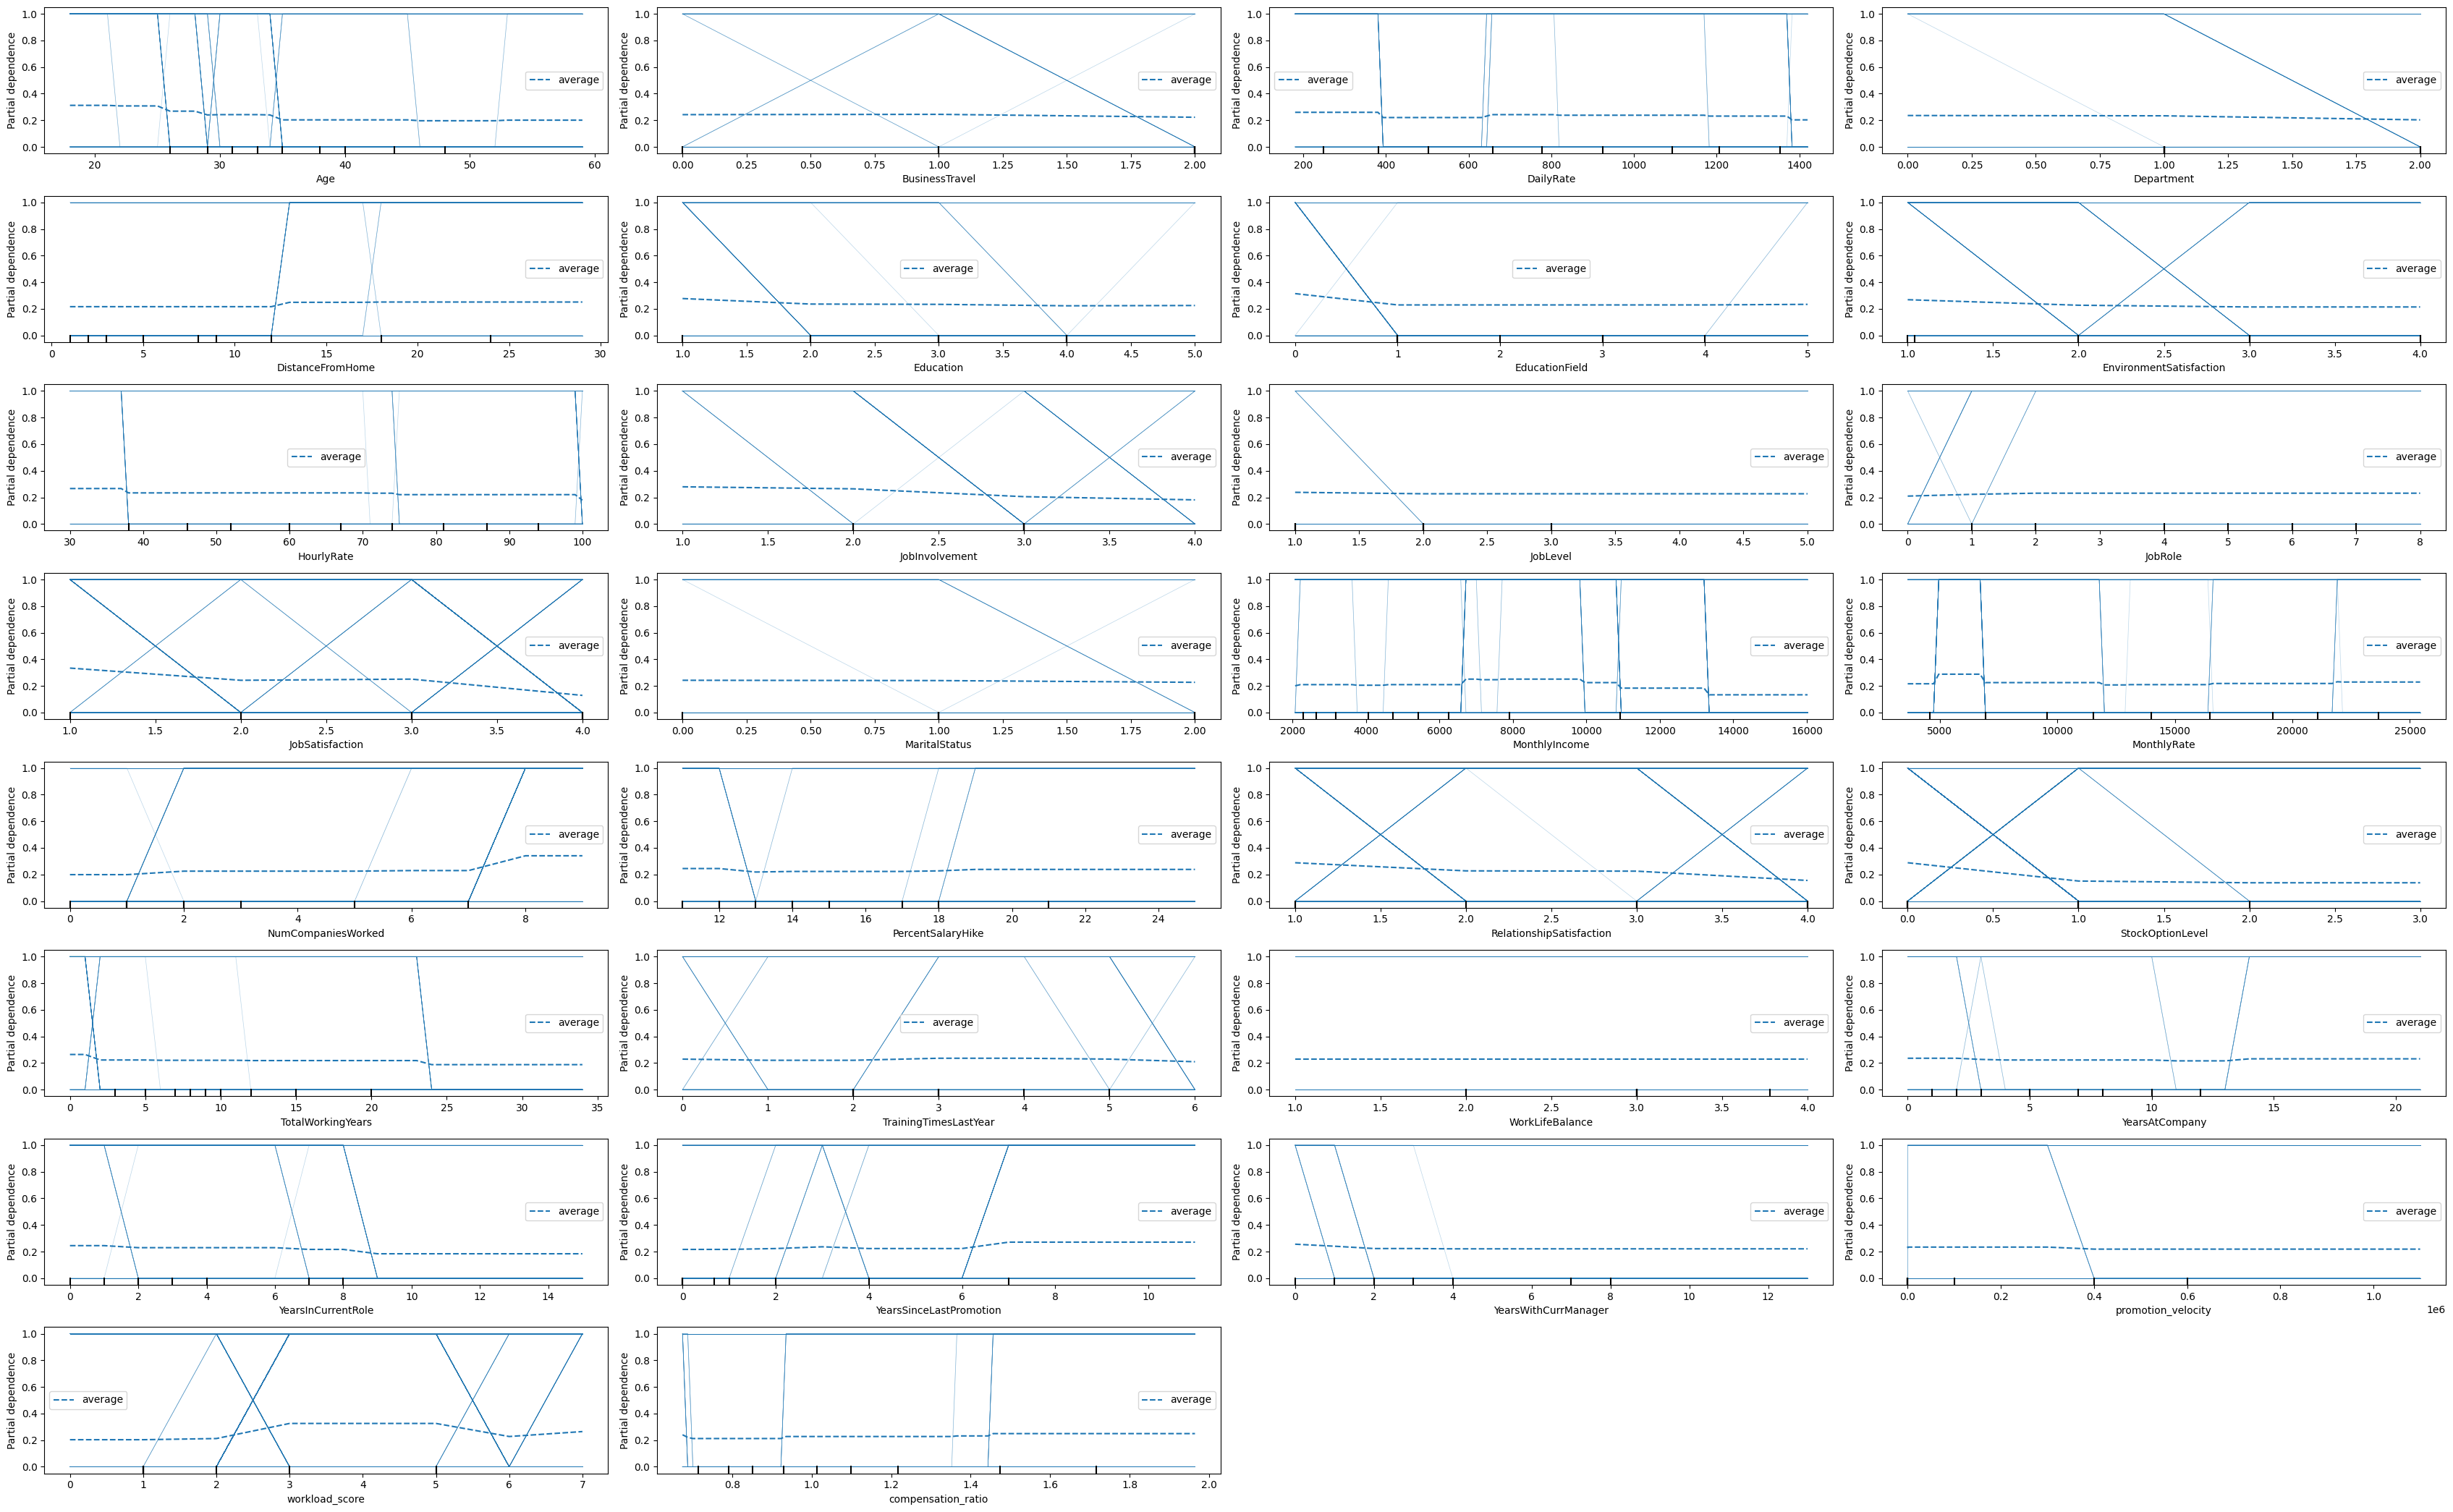

In [23]:
cols = [c for c in X_test.columns if X_test[c].nunique() > 2]

nc = 4
nr = (len(cols) + nc - 1) // nc

fig, axes = plt.subplots(nr, nc, figsize=(34, 21))

for ax, feat in zip(axes.flatten(), cols):
    PartialDependenceDisplay.from_estimator(
        decision_tree_clf,
        X_test,
        [feat],
        ax=ax,
        kind='both'
    )

for i in range(len(cols), nr * nc):
     if i < len(axes_pdp.flatten()):
        fig.delaxes(axes.flatten()[i])

plt.tight_layout()

* Each line represents a single instance (employee) from the subsample used for plotting. It shows how the model's predicted probability of attrition *for that specific employee* changes as the feature on the x-axis varies, keeping all other features constant at that employee's original values.

*   **Average Line (---------):** This line represents the **average of the specific ICE lines shown in the plot**.

*   **High Heterogeneity & Sharp Jumps:** The wide variation and frequent crossing of the thin ICE lines highlight strong interaction effects within the model. The sharp are characteristic of the Decision Tree's rule-based predictions, showing how crossing specific feature thresholds can drastically change an individual's predicted outcome.

**Insight:** These plots reveal the significant variations in how individual predictions respond to feature changes, which are averaged out in the PDP.